# Road segmentation: Train-Test

The aim of this notebook is to:

- Split the training dataset into a train and a test set
- Train the U-Net neural network on the training set
- Test the model on the test set

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
import sys
import time

import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms

In [63]:
# Run this cell only if you run this notebook on Google Colab.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Run this cell only if you run this notebook on Google Colab.
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

sys.path.append('/content/drive/Shareddrives/ML')

/device:GPU:0


In [ ]:
# Run this cell only if you do NOT run this notebook on Google Colab.
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

In [65]:
# Imports from src
from src.datasets import SatelliteImagesDataset, train_test_split
from src.models import SegNet, UNet
from src.path import (DATA_TRAIN_GT_PATH, DATA_TRAIN_IMG_PATH, MODELS_DIR,
                      create_dirs, extract_archives)
from src.plot_utils import plot_images
from src.trainer import Trainer

In [66]:
# Config
BATCH_SIZE = 1
EPOCHS = 300
IMG_HEIGHT = 320
IMG_WIDTH = 320
LR = 1e-3
SEED = 0
SPLIT_RATIO = 0.2
WORKERS = 2

# Paths
timestr = time.strftime('%Y%m%d')

model_filename = f'model-train-test-{timestr}.pt'
MODEL_PATH = os.path.join(MODELS_DIR, model_filename)
print('Model file:', MODEL_PATH)

log_filename = f'log-train-test-{timestr}.pickle'
LOG_PATH = os.path.join(MODELS_DIR, log_filename)
print('Log file:', LOG_PATH)

Model file: /content/drive/Shareddrives/ML/models/model-train-test-20211129.pt
Log file: /content/drive/Shareddrives/ML/models/log-train-test-20211129.pickle


In [67]:
# Extract archives and create directories if needed
create_dirs()
extract_archives()

In [68]:
# Set seed
torch.manual_seed(SEED)

In [69]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
pin_memory = device == 'cuda'

Device: cuda


In [70]:
# Define transforms
image_transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
])

# Define dataset
dataset = SatelliteImagesDataset(
    img_dir=DATA_TRAIN_IMG_PATH,
    gt_dir=DATA_TRAIN_GT_PATH,
    image_transform=image_transform,
    mask_transform=mask_transform,
)
print('Size of dataset:', len(dataset))

Size of dataset: 100


Image size: torch.Size([3, 320, 320])
Mask size: torch.Size([1, 320, 320])


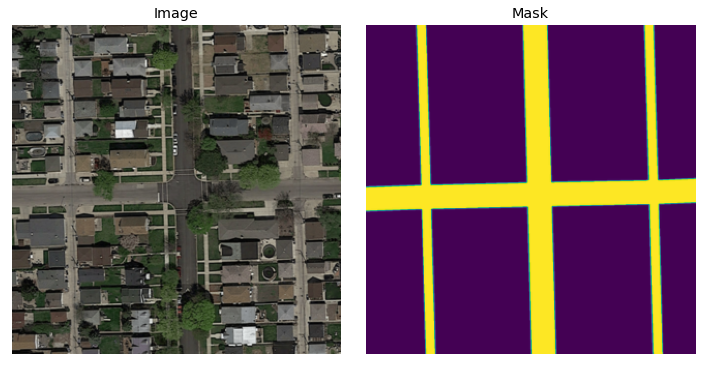

In [71]:
# Sample of image/mask
image, mask = dataset[0]
print('Image size:', image.shape)
print('Mask size:', mask.shape)
plot_images(image, mask)

In [72]:
# Split train test
train_set, test_set = train_test_split(dataset=dataset, test_ratio=SPLIT_RATIO)
print('Train size:', len(train_set))
print('Test size:', len(test_set))

# Define loaders
train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)
test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)

Train size: 80
Test size: 20


In [73]:
# Define neural net
model = SegNet()
# model = UNet()
model.to(device)

SegNet(
  (MaxEn): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ConvEn11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn11): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn12): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn21): BatchNorm2d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn22): BatchNorm2d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn31): BatchNorm2d(256, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn32): Conv2d(256, 256, kernel_s

In [74]:
# Define loss function and optimizer
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [75]:
# Define trainer
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    weights_path=MODEL_PATH,
    log_path=LOG_PATH,
    data_loader=train_loader,
    valid_data_loader=test_loader,
    notebook=True,
)

In [76]:
# Launch training
trainer.train(epochs=EPOCHS)

Start training.


Training:   0%|          | 0/300 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 1:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 2:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 2:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 3:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 3:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 4:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 4:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 5:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 5:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 6:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 6:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 7:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 7:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 8:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 8:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 9:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 9:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 10:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 10:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 11:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 11:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 12:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 12:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 13:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 13:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 14:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 14:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 15:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 15:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 16:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 16:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 17:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 17:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 18:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 18:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 19:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 19:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 20:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 20:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 21:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 21:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 22:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 22:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 23:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 23:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 24:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 24:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 25:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 25:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 26:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 26:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 27:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 27:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 28:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 28:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 29:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 29:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 30:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 30:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 31:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 31:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 32:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 32:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 33:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 33:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 34:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 34:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 35:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 35:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 36:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 36:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 37:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 37:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 38:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 38:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 39:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 39:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 40:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 40:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 41:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 41:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 42:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 42:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 43:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 43:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 44:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 44:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 45:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 45:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 46:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 46:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 47:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 47:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 48:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 48:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 49:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 49:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 50:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 50:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 51:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 51:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 52:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 52:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 53:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 53:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 54:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 54:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 55:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 55:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 56:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 56:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 57:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 57:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 58:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 58:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 59:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 59:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 60:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 60:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 61:   0%|          | 0/80 [00:00<?, ?batch/s]

EarlyStopping: Stop training at epoch 61.
End training. Time: 1872.274s.


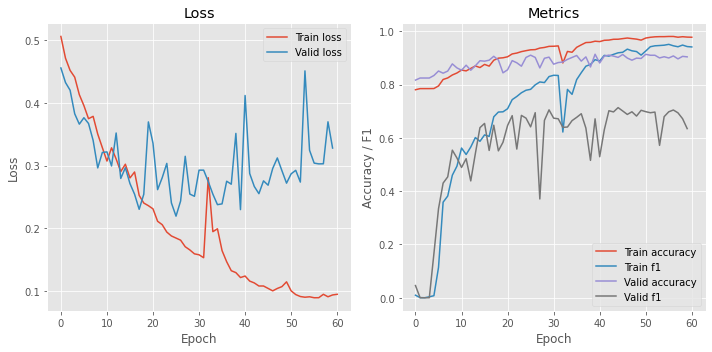

In [77]:
# Plot history
trainer.history.plot()